# SSC0275 - Ciências de Dados
## Rodrigo Geurgas Zavarizz - 9791080 / Victor Henrique Rodrigues - 9791027

In [13]:
import pandas as pd
import numpy as np
from sklearn import datasets 

escolas = pd.read_csv('datasets/instituicoes_ensino_basico/CADASTRO_MATRICULAS_REGIAO_SUDESTE_SP_2012.csv', sep=';', header=11, encoding='latin1', low_memory = False)

In [14]:
escolas = escolas[['MATTOTAL', 'NUM_SALAS_EXISTENTES', 'REDE', 'NUM_FUNCIONARIOS']]
#escolas

In [15]:
cleanescolas = escolas.dropna()
print(f'Porcentagem de amostras com elementos nulos {(1-len(cleanescolas)/len(escolas))*100:.2f}%')
cleanescolas = cleanescolas.drop_duplicates()
print(f'Porcentagem de amostras com elementos nulos ou amostras duplicadas {(1-len(cleanescolas)/len(escolas))*100:.2f}%')

Porcentagem de amostras com elementos nulos 9.01%
Porcentagem de amostras com elementos nulos ou amostras duplicadas 16.88%


In [16]:
print(f'Porcentagem de número de matrículas menores ou iguais a zero: {len(cleanescolas[cleanescolas.MATTOTAL <= 0].MATTOTAL)/len(cleanescolas)*100:.2f}%')
print(f'Número de salas menor ou igual a zero: {len(cleanescolas[cleanescolas.NUM_SALAS_EXISTENTES <= 0].NUM_SALAS_EXISTENTES):.0f}')
print(f'Número de funcionários menor ou igual a zero: {len(cleanescolas[cleanescolas.NUM_FUNCIONARIOS <= 0].NUM_FUNCIONARIOS):.0f}')

Porcentagem de número de matrículas menores ou iguais a zero: 1.32%
Número de salas menor ou igual a zero: 0
Número de funcionários menor ou igual a zero: 0


In [18]:
print(cleanescolas.max())

MATTOTAL                    999
NUM_SALAS_EXISTENTES        125
REDE                    Pública
NUM_FUNCIONARIOS           1699
dtype: object


A partir da execução acima, perce-be se que os valores não estão exageradamente grandes a ponto de serem considerados outliers.

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


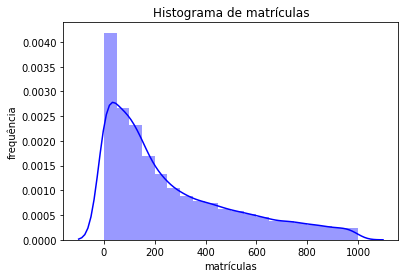

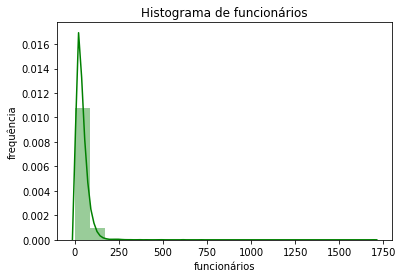

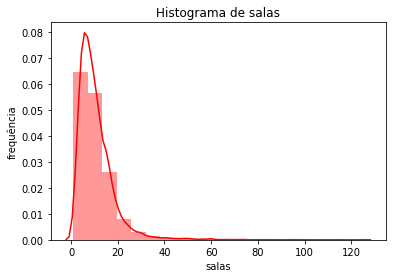

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.distplot(cleanescolas.MATTOTAL, bins=20, label='Pública', color='b')
plt.xlabel('matrículas')
plt.ylabel('frequência')
plt.title('Histograma de matrículas')
plt.show()

sns.distplot(cleanescolas.NUM_FUNCIONARIOS, bins=20, label='Pública', color='g')
plt.xlabel('funcionários')
plt.ylabel('frequência')
plt.title('Histograma de funcionários')
plt.show()

sns.distplot(cleanescolas.NUM_SALAS_EXISTENTES, bins=20, label='Pública', color='r')
plt.xlabel('salas')
plt.ylabel('frequência')
plt.title('Histograma de salas')
plt.show()

In [20]:
publicas = cleanescolas[cleanescolas.REDE != 'Pública']
print(f"Número de escolas que não colocaram nem públicas e nem privadas: {len(publicas[publicas.REDE != 'Privada'])}")

Número de escolas que não colocaram nem públicas e nem privadas: 0


In [21]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def reg_clas(data, columns, target, regression=False):
    """
    Executa classificação ou regressão do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    regression: Boleano. True para realizar uma regressão e False para classificação
    ---------------------------------------------------------------
    Realiza a classificação/regressão em 4 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, e knn com k=5)
    Plot o gráfico de desempenho para cada classificador/regressor.
    Retorna um dicionário com os classificadores/regressores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    if regression:
        svm_l = SVR(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVR(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_split=int(len(data)*0.05))
        knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    else:
        svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
        knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    
    clfs = [svm_l, svm_n, dt, knn]
    clfs_names = ['svm_linear', 'svm_poly', 'dt', 'knn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[], 'knn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            if regression:
                results[c_name].append( mean_squared_error(clf.predict(x_test), y_test) )
            else:
                results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores/regressores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos regressores - erro quadrático médio' if regression else \
            'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cleanescolas.REDE = le.fit_transform(cleanescolas.REDE)

clf = reg_clas(cleanescolas, [0, 1, 3], 2, regression=False)

In [ ]:
reg = reg_clas(cleanescolas, [0, 1, 3], 2, regression=True)

#### Comentários:

- Nesse programa, consideramos como problema valores ausentes e valores duplicados.
- Alguns problemas tem origem aleatória, pois não há explicação para determinado atributo ter valor zero, enquanto que ontros tem origem sistematica pois todos os atributos estão zerados.
- Para a limpeza foi removido os elementos que continham valores nulos, uma vez que não eram muitos, e com isso consideramos apenas valores legitimos ao invés de colocar aproximações na base.
- A partir da execução dos classificadores, usando como rótulo o tipo de escolas e sem regressão, tivemos que o knn teve o melhor desempenho obtendo entre 0.7-0.8 de acurácia.
- Para a regressão, percebemos que o erro quadratico gira em torno de 0.0 e 0.4
- Para a base sem limpeza, por conter valores NaN, o algortimo não roda.

In [ ]:
#clf = reg_clas(escolas, [0, 1, 3], 2, regression=False)